In [2]:
#import os
#print(os.environ['PIP_DEFAULT_TIMEOUT'])
## export PIP_DEFAULT_TIMEOUT=100

2


In [1]:
import sys
print(sys.version)

3.6.8 (default, Jan 14 2019, 11:02:34) 
[GCC 8.0.1 20180414 (experimental) [trunk revision 259383]]


In [29]:
from __future__ import division

from math import sqrt, cos, sin, acos, pi, atan2
from matplotlib import cm
from matplotlib import patches
from matplotlib.colors import LogNorm
from matplotlib.path import Path
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

#custom module
#from fieldplot import GetFlow3D
#from nanoscale_test import fieldplot2, rotateAroundX, rotateAroundY, rotateAroundZ, angle2D
#from scattnlay import fieldnlay
#from scattnlay import scattnlay

#import nanoscale_test
#import scattnlay

#%run kostin_kod.py

import cma
import sphereml
from scipy.optimize import differential_evolution
from pyfde import JADE
%run algorithms/genetic.py
import time

from joblib import Parallel, delayed
import pyformulas as pf

factor=1.3					# area of plot

/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [30]:
def evaluate(ind, layers=2):
    assert len(ind)==layers*3+1
    
    r = ind[-1]
    x = ind[:layers]
    m_ = ind[layers:3*layers][::2]
    m_j = ind[layers:3*layers][1::2]
    m = map(lambda t: t[0]+t[1]*1j, zip(m_, m_j))
    
    m = [z for _,z in sorted(zip(x,m), key=lambda pair: pair[0])]
    x = sorted(x)
    
    m = np.array(m)
    x = np.array(x)
    
    px = 1.
    py = 0.
    pz = 0.

    wl = 0.455
    NL = layers
    RL = np.zeros(NL)
    eL = np.zeros(NL+1, dtype=complex)
    eL[:NL] = m[:]
    eL[NL] = 1.
    RL[:] = x[:] / 1000.0
    Rd = r / 1000.0
    
    res = sphereml.evaluate_directivity(RL, eL, Rd, wl, px, py, pz, np.pi, 0.)
    if np.isnan(res): 
        print("!!! ERROR {}".format(ind))
        print(" eL:{}".format(eL))
        print(" RL:{}".format(RL))
        print("  x:{}".format(x))
    
    return res

In [31]:
def run_evaluation(algo, n_it, r_limits, m_limits, mj_limits, layers, evaluate=evaluate, popsize=None, 
                   sigma=0.1, adapt_sigma='True',#cma.sigma_adaptation.CMAAdaptSigmaCSA,
                   sbbx_eta=1.0, log=True,
                   seed=283636):
    def helper(ind):
        helper.calls += 1
        return evaluate(ind, layers=layers)
    helper.calls = 0
    
    hist = []
    limits = [r_limits]*layers+[m_limits,mj_limits]*layers+[(0.1, r_limits[-1]*factor)]
    
    if popsize is None: popsize = 5*len(limits)
    
    def gen_callback(fitness):
        hist.append((helper.calls, fitness))
        #print("hist: {} {}".format(len(hist), hist[-1]))
        if helper.calls > n_it:
            return True
    
    if algo == 'JADE':
        solver = JADE(helper, n_dim=len(limits), n_pop=popsize, limits=limits)
        for _ in range(int(n_it/popsize)):
            best, fit = solver.run(n_it=1)
            hist.append((helper.calls, fit))
            
    elif algo == 'DE':
        def de_callback(xk, convergence):
            hist.append((helper.calls, evaluate(xk, layers)))
            if helper.calls > n_it:
                return True
        
        result = differential_evolution(lambda t: -helper(t), limits,
                               callback=de_callback, popsize=popsize, maxiter=n_it)
        best, fit = result.x, -result.fun
    
    elif algo == 'genetic':
        best, fit = genetic(helper,
                            limits=limits, popsize=popsize, generations=n_it, sbbx_eta=sbbx_eta, log=False,
                            callback=gen_callback)
    elif algo == '1+1':
        best, fit = one_plus_one(helper, limits=limits, log=False, callback=gen_callback)
    elif algo == 'CMA':
        initial=get_ind_function(limits)
        #sigma=0.1
        CMA_stds=[1.0 / r_limits[1]]*layers+[1.0/m_limits[1],1.0/mj_limits[1]]*layers+[1.0/r_limits[-1]/factor]
        bounds=[list(map(lambda t: t[0], limits)), list(map(lambda t: t[1], limits))]
        options={
            'CMA_stds': CMA_stds, 
            'bounds': bounds, 
            #'seed': seed,
            'AdaptSigma': adapt_sigma,
            'verbose': -9
        }
        es = cma.CMAEvolutionStrategy(initial, sigma, options)
        for _ in range(n_it):
            (solutions, func_values) = es.ask_and_eval(lambda t: -helper(t))
            es.tell(solutions, func_values)
            try:
                fit, best = min(zip(func_values, solutions), key=lambda t: t[0])
            except Exception:
                print("{} {}".format(func_values, solutions))
                assert False
            hist.append((helper.calls, -fit))
            if helper.calls > n_it:
                break
    else:
        raise AssertionError("Unknown algo")
    
    if log:
        print("{}: best {} for ind {}".format(algo, fit, best))
    return best, fit, hist

In [5]:
class Evaluator:
    def __init__(self, algo, options, r_limits, m_limits, mj_limits, layers, callback):
        self.limits = [r_limits]*layers+[m_limits,mj_limits]*layers+[(0.1, r_limits[-1]*factor)]
        self.layers = layers
        self.callback = callback
        self.algo_args = options
        
        self.CMA_stds=[1.0/r_limits[1]]*layers+[1.0/m_limits[1],1.0/mj_limits[1]]*layers+[1.0/r_limits[-1]/factor]
        
        self.algo_args.setdefault('sigma', 0.1)
        self.algo_args.setdefault('adapt_sigma', 'True')
        #self.algo_args.setdefault('seed', 283636)
        self.algo_args.setdefault('popsize', 5*len(limits))
        self.algo_args.setdefault('sbbx_eta', 1.0)
        
    def run(self, n_it):
        def helper(ind):
            helper.calls += 1
            return evaluate(ind, layers=self.layers)
        helper.calls = 0
        
        def gen_callback(individuals):
            """List of pairs of (ind, fit)"""
            best, best_fit = max(individuals, key=lambda t: t[1])
            callback(helper.calls, best, best_fit, individuals)
            if helper.calls > n_it:
                return True

        if algo == 'JADE':
            solver = JADE(helper, n_dim=len(self.limits), n_pop=self.popsize, limits=self.limits)
            for _ in range(int(n_it/popsize)):
                best, fit = solver.run(n_it=1)
                callback(helper.calls, best, fit)

        elif algo == 'DE':
            def de_callback(xk, convergence):
                callback(helper.calls, xk, evaluate(xk, layers))
                if helper.calls > n_it:
                    return True

            result = differential_evolution(lambda t: -helper(t), self.limits, polish=False,
                                   callback=de_callback, popsize=self.popsize, maxiter=n_it)
            best, fit = result.x, -result.fun

        elif algo == 'genetic':
            best, fit = genetic(helper,
                                limits=self.limits, popsize=self.popsize, generations=n_it, 
                                sbbx_eta=self.algo_args['sbbx_eta'], log=False, callback=gen_callback)
        elif algo == '1+1':
            best, fit = one_plus_one(helper, limits=self.limits, log=False, callback=gen_callback)
        elif algo == 'CMA':
            initial=get_ind_function(self.limits)
            options={
                'CMA_stds': self.CMA_stds,
                'bounds': list(zip(*self.limits)),
                #'seed': seed,
                'AdaptSigma': self.algo_args['adapt_sigma'],
                'verbose': -9
            }
            es = cma.CMAEvolutionStrategy(initial, self.algo_args['sigma'], options)
            for _ in range(n_it):
                solutions, func_values = es.ask_and_eval(lambda t: -helper(t))
                es.tell(solutions, func_values)
                func_values = [-t for t in func_values]
                individuals = list(zip(solutions, func_values))
                try:
                    best, fit = max(individuals, key=lambda t: t[1])
                except Exception:
                    print("{} {}".format(func_values, solutions))
                    assert False
                callback(helper.calls, best, fit, individuals)
                if helper.calls > n_it:
                    break
        else:
            raise AssertionError("Unknown algo")

In [6]:
def run_evaluations(algorithms, n_it, r_limits, m_limits, mj_limits, layers, callback,
                    store_every, retries, plot, update_every = None):
    """
    algorithms:  [('CMA', options)]
    n_it:        400000
    store_every: 1
    retries:     1
    plot:        ['online', 'best', 'boxplot']
        'online' draws every retry online
        'best' draws one plot with best algos from each try
        'boxplot' draws one boxplot
    """
    
    def get_name(algo, options, retry):
        res = algo
        # TODO: options
        if retry is not None:
            res += "_{}".format(str(retry))
        return res
    
    def update_plot_online(task, ax, fig):
        z = zip(range(len(task.shared.hist)), task.shared.hist)
        z = list(filter(lambda t: t[1] != 0, z))
        xs, ys = list(zip(*z))
        task.line2d.set_data(xs, ys)
            
    if update_every is None: update_every = n_it // 100
    
    for retry in range(retries):
        tasks = []
        for i, (algo, options) in enumerate(algorithms):
            task = type('Task', (), {})()
            tasks.append(task)
            
            #task.algo = algo
            #task.line2d, = axes.plot([], [], label=get_name(algo, options, None))
            task.shared = type('Task.Shared', (), {})()
            task.shared.name = get_name(algo, options, retry) + "_{}".format(i)
            task.shared.evaluator = Evaluator(algo, options, r_limits, m_limits, mj_limits, layers, callback)
            task.shared.data = []
            task.shared.i = i
            task.shared.hist = np.memmap("data/{}.hist".format(task.shared.name), shape=n_it, 
                                         dtype='float64', mode='w+')
            task.shared.finished = np.memmap("data/{}.finished".format(task.shared.name), shape=1, 
                                         dtype='bool', mode='w+')
            task.shared.last_store = 0
        
        def run_task(task):
            print("Start {}".format(task.i))
            task.evaluator.init()
            while task.evaluator.fitness_calls < n_it:
                individuals, fits = task.evaluator.do_step()
                #if task.evaluator.fitness_calls > task.last_store + store_every:
                #    task.last_store = task.evaluator.fitness_calls
                #    task.data.append((task.evaluator.fitness_calls, individuals, fits))
                if task.evaluator.fitness_calls < n_it:
                    task.hist[task.evaluator.fitness_calls] = max(fits)
            task.finished[0] = True
            print("Fin {}".format(task.i))
            
        def draw_job(tasks, retry_number):
            print("Start draw")
            
            figure = plt.figure(retry_number + 1)#, figsize=(16,8))
            axes = figure.gca()
            axes.set_title("Retry {}".format(retry_number))
            for task in tasks:
                task.line2d, = axes.plot([], [], label=get_name(algo, options, None))
            axes.legend()
            
            canvas = np.zeros((480,640))
            screen = pf.screen(canvas, 'My super figure')
            
            figure.canvas.draw()
            f = True
            while f:
                time.sleep(3)
                f = False
                for task in tasks:
                    f |= not task.shared.finished[0]
                    update_plot_online(task, axes, figure)
                    
                axes.relim()
                axes.autoscale_view()
                plt.show()
                ttime = time.time()
                figure.canvas.draw()
                drawtime = time.time() - ttime
                print("draw time: {} sec".format(drawtime))
                
                image = np.fromstring(figure.canvas.tostring_rgb(), dtype=np.uint8, sep='')
                image = image.reshape(figure.canvas.get_width_height()[::-1] + (3,))
                screen.update(image)
            screen.close()
            print("Fin draw")
        
        parallel_jobs = [delayed(run_task)(task.shared) for task in tasks] + \
                        [delayed(draw_job)(tasks, retry)]
        Parallel(n_jobs=len(parallel_jobs), backend='threading')(parallel_jobs)
        print("Fin")

In [7]:
%%time
%matplotlib notebook
def callback(fitness_calls, best, best_fit, individuals):
    

run_evaluations([
    ('JADE', {})
], 10000, layers=3, callback, store_every=10, retries=1, plot='online', **limitsdict)

IndentationError: expected an indented block (<unknown>, line 5)

In [7]:
limitsdict = {'r_limits':(10,120), 'm_limits':(3, 10), 'mj_limits':(0, 0.4)}

def plot_hist(hist, label, linestyle='-'):
    histarr = np.array(hist)
    xs,ys = histarr[:,0],histarr[:,1]
    plt.plot(xs, ys, linestyle=linestyle, label=label)

In [48]:
def calc_something(layers, r_limits, m_limits, mj_limits):
    limits = [r_limits]*layers+[m_limits,mj_limits]*layers+[(0.1, r_limits[-1]*factor)]
    CMA_stds=[1.0 / r_limits[1]]*layers+[1.0 / m_limits[1], 1.0 / mj_limits[1]]*layers+[1.0 / r_limits[-1]/factor]
    return limits, CMA_stds
layers = 1
limits, CMA_stds = calc_something(layers, **limitsdict)
initial=get_ind_function(limits)
sigma=.1
bounds=list(zip(*limits))
options={'CMA_stds': CMA_stds, 'bounds': bounds}
es = cma.CMAEvolutionStrategy(initial, sigma, options)
#es = cma.CMAEvolutionStrategy(initial, sigma)
#es.optimize(lambda t: -evaluate(t, layers=1))
solutions, func_values = es.ask_and_eval(lambda t: -evaluate(t, layers=1))

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=1029461, Wed Aug 28 00:38:41 2019)


In [44]:
options

{'CMA_stds': [0.002, 0.1, 2.5, 0.0015384615384615385],
 'bounds': [(10, 3, 0, 0.1), (500, 10, 0.4, 650.0)]}

<IPython.core.display.Javascript object>


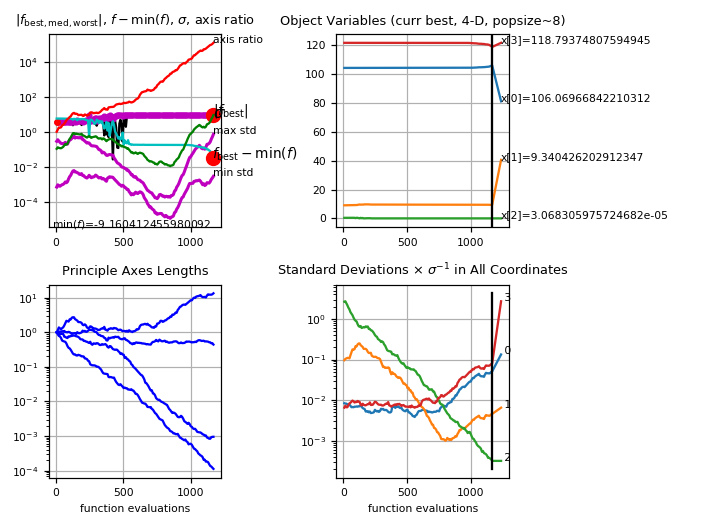

In [46]:
#%matplotlib notebook
es.plot();

CMA: best -14.355774439053908 for ind [4.98976764e+01 3.79208722e+02 1.02698711e+02 1.40546583e+02
 3.48577475e-01]
CMA: best -13.772602516941028 for ind [388.51372039  96.4060745  136.14676327  91.19144695   0.85691078]
CMA: best -2.034704103286214 for ind [ 44.77286241  78.28184235  12.77236141 451.39476788   0.99559497]
CMA: best -10.71763045143818 for ind [2.24691428e+02 4.35772357e+02 2.10986691e+02 4.51368250e+01
 2.98255230e-01]
CPU times: user 16.2 s, sys: 4.04 ms, total: 16.2 s
Wall time: 16.2 s


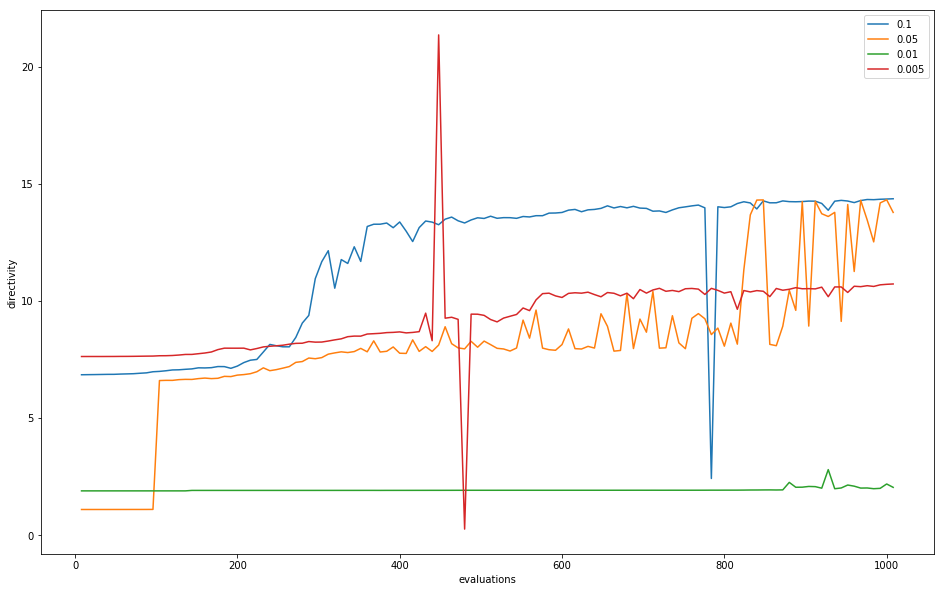

In [48]:
%%time
results = []
n_it=1000
for l in [.1, .05, .01, 0.005]:
    _, _, hist = run_evaluation('CMA', n_it=n_it, layers=3, sigma=l, **limitsdict)
    results.append((hist, str(l)))
    
plt.figure(figsize=(16,10))
plt.xlabel("evaluations")
plt.ylabel("directivity")
for hist,label in results:
    plot_hist(hist, label)
plt.legend();

CMA: best -22.613654353600975 for ind [497.29351831 181.1392218  106.33122429 219.99870917   0.55862531]
CMA: best -7.752652448414905 for ind [403.76277505 295.69405624  82.35090737 346.05062439   0.86350469]
CMA: best -6.860899561697945 for ind [139.88950581 170.59604554  10.96881409 180.27191937   0.28790638]
CMA: best -17.039549381688364 for ind [ 64.13273779 449.18698443 448.62408632 474.93757174   0.67715458]
CPU times: user 16.4 s, sys: 2.1 ms, total: 16.4 s
Wall time: 16.4 s


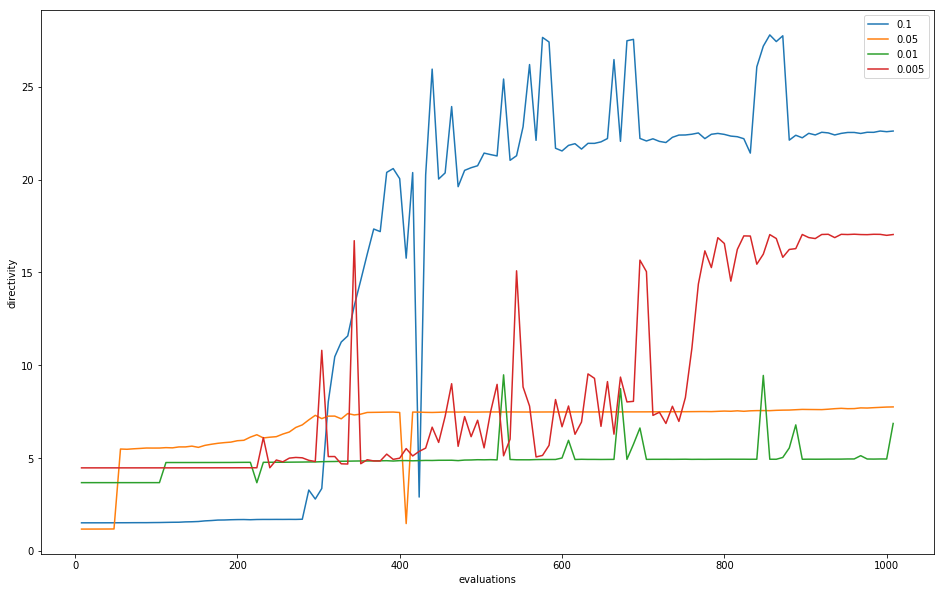

In [49]:
%%time
results = []
n_it=1000
for l in [.1, .05, .01, 0.005]:
    _, _, hist = run_evaluation('CMA', n_it=n_it, layers=3, sigma=l, **limitsdict)
    results.append((hist, str(l)))
    
plt.figure(figsize=(16,10))
plt.xlabel("evaluations")
plt.ylabel("directivity")
for hist,label in results:
    plot_hist(hist, label)
plt.legend();

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=318787, Tue Apr  2 00:02:18 2019)
CMA: best -4.32692122982 for ind [1.00063696e+02 1.07926031e+02 1.69121413e+01 8.31846280e+00
 9.78840688e-03 8.81899965e+00 1.51151162e-01 4.30494015e+00
 2.60689288e-01 5.69145848e+01]
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=176193, Tue Apr  2 00:02:24 2019)
CMA: best -5.10568632072 for ind [5.63276421e+01 9.95294620e+01 3.58476423e+01 9.89540966e+00
 3.42424103e-01 4.49057377e+00 5.74061925e-02 9.99845581e+00
 1.43281162e-01 1.37834420e+02]
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=233097, Tue Apr  2 00:02:29 2019)
CMA: best -0.307577507542 for ind [8.24120900e+01 3.66374652e+01 6.20481539e+01 3.91429614e+00
 7.81718777e-03 8.53433766e+00 8.60311765e-06 6.37853125e+00
 5.51965757e-04 2.79897455e+01]
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=250464, Tue Apr  2 00:02:33 2019)
CMA: best -8.35557332657 for ind [6.38526138e+01 1.06893377e+02 1.0796

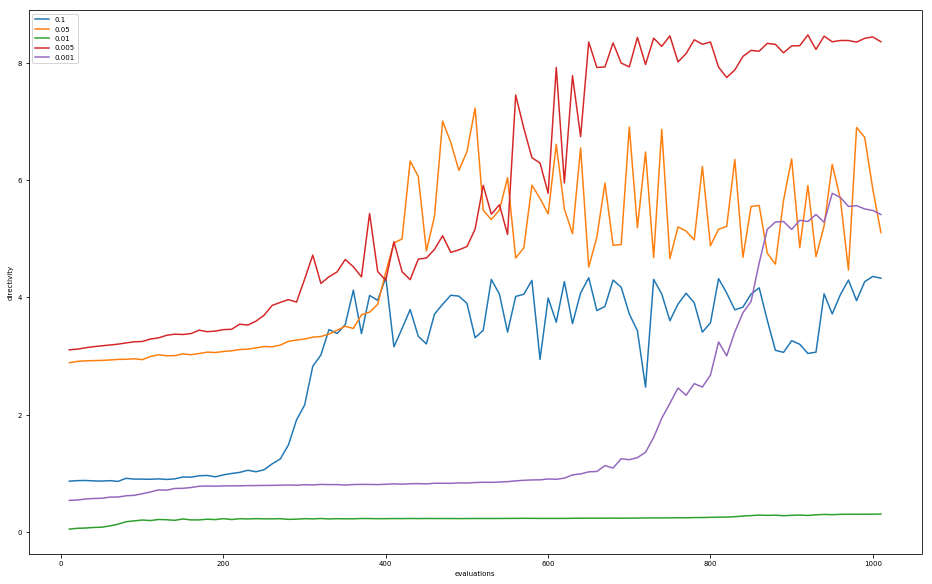

In [95]:
%%time
results = []
n_it=1000
for l in [.1, .05, .01, 0.005, 0.001]:
    _, _, hist = run_evaluation('CMA', n_it=n_it, layers=3, sigma=l, **limitsdict)
    results.append((hist, str(l)))
    
plt.figure(figsize=(16,10))
plt.xlabel("evaluations")
plt.ylabel("directivity")
for hist,label in results:
    plot_hist(hist, label)
plt.legend();

CMA: best -9.704098610877894 for ind [1.62748596e+02 1.59305192e+02 3.85781543e-02]
CMA: best -17.828880520142125 for ind [448.33312077 329.48167361 470.35135649   0.85451149]
CMA: best -5.651739759770863 for ind [1.53095795e+01 2.06182437e+02 3.88669026e+02 5.28999591e+02
 3.54996116e-01]
CMA: best -8.8067454951217 for ind [ 80.20560643 374.53559078  62.02847555 203.26266946  34.63492603
   0.90344184]
CMA: best -7.400918041525874 for ind [177.88953762 110.85532166 132.50188214 392.09993975 194.73374306
 374.84508394   0.98134533]
CPU times: user 24.7 s, sys: 8.5 s, total: 33.2 s
Wall time: 20.9 s


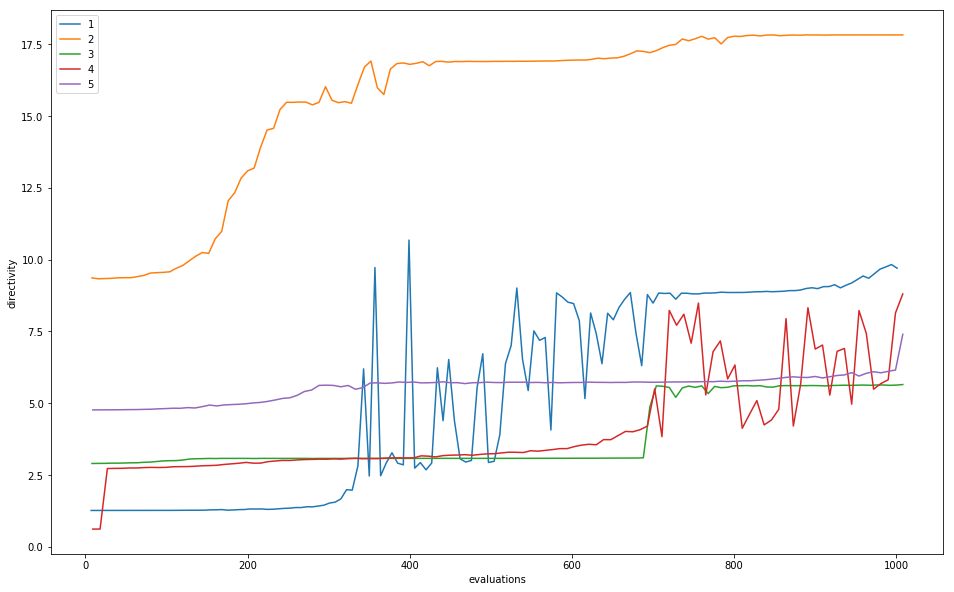

In [50]:
%%time
results = []
n_it=1000
for l in [1, 2, 3, 4, 5]:
    _, _, hist = run_evaluation('CMA', n_it=n_it, layers=l, sigma=0.1, **limitsdict)
    results.append((hist, str(l)))
    
plt.figure(figsize=(16,10))
plt.xlabel("evaluations")
plt.ylabel("directivity")
for hist,label in results:
    plot_hist(hist, label)
plt.legend();

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=305481, Tue Apr  2 00:04:44 2019)
CMA: best -6.74211503537 for ind [1.11495049e+02 3.64615878e+00 9.20902462e-05 5.39790156e+01]
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=270529, Tue Apr  2 00:04:46 2019)
CMA: best -7.53574896296 for ind [1.11730290e+02 7.97141125e+00 4.69992383e-03 1.30605550e+02]
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=284373, Tue Apr  2 00:04:48 2019)
CMA: best -8.21896752491 for ind [1.04406028e+02 7.20552149e+00 8.18493812e-10 1.45586576e+02]
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=181428, Tue Apr  2 00:04:50 2019)
CMA: best -2.50649330387 for ind [1.17537219e+02 7.78186046e+00 1.22204449e-05 3.46804373e+00]
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=242004, Tue Apr  2 00:04:51 2019)
CMA: best -4.17113999565 for ind [1.02277345e+02 5.41068422e+00 2.76121522e-02 1.23055440e+02]
CPU times: user 8.35 s, sys: 46.5 ms, total: 8.39 s
Wall time: 8.37 s


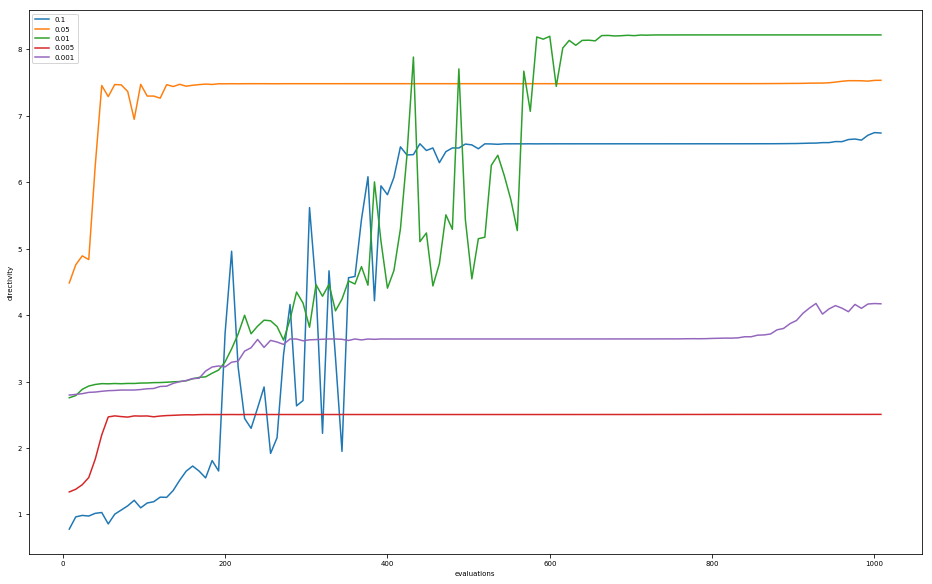

In [97]:
%%time
results = []
n_it=1000
for l in [.1, .05, .01, 0.005, 0.001]:
    _, _, hist = run_evaluation('CMA', n_it=n_it, layers=1, sigma=l, **limitsdict)
    results.append((hist, str(l)))
    
plt.figure(figsize=(16,10))
plt.xlabel("evaluations")
plt.ylabel("directivity")
for hist,label in results:
    plot_hist(hist, label)
plt.legend();

(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 7 (seed=329719, Tue Apr  2 00:05:14 2019)
CMA: best -2.93302863721 for ind [5.42396887e+01 1.67522701e+01 4.16908239e+00 1.78720725e-01
 4.56988551e+00 1.80316920e-02 9.06718813e+00]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 7 (seed=243221, Tue Apr  2 00:05:18 2019)
CMA: best -8.12723986852 for ind [1.03857784e+02 6.12175766e+01 4.36756311e+00 6.44173256e-03
 8.73281567e+00 2.57621684e-02 1.52188960e+02]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 7 (seed=196638, Tue Apr  2 00:05:21 2019)
CMA: best -7.427215331 for ind [3.20873520e+01 1.03570959e+02 3.15915634e+00 1.78242796e-04
 8.27989243e+00 2.63388333e-03 2.83851121e+01]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 7 (seed=342772, Tue Apr  2 00:05:24 2019)
CMA: best -4.04398696174 for ind [8.61167698e+01 1.04866274e+02 3.24232120e+00 1.07667661e-01
 7.28572107e+00 2.69729898e-02 1.08467960e+02]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 7 (seed=271172, Tue Apr  2 00:

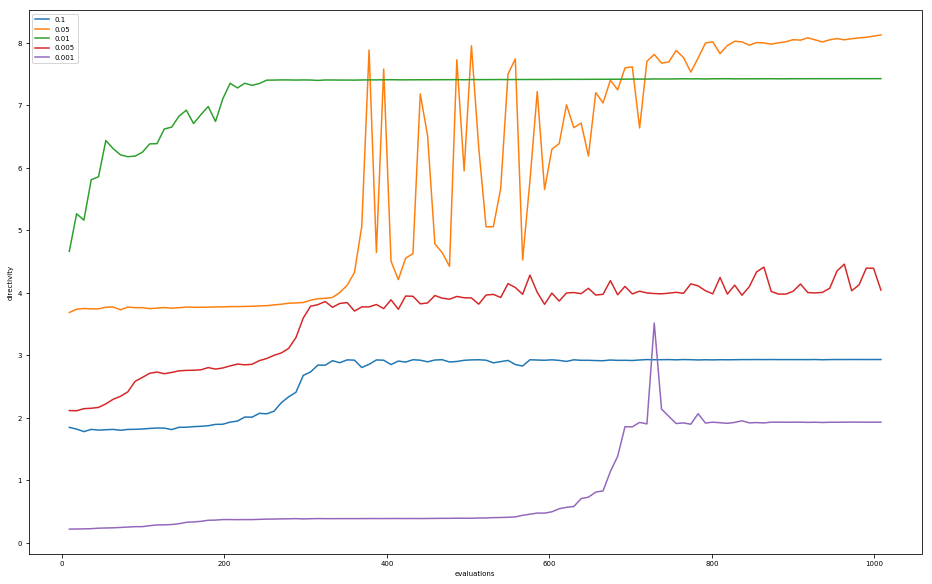

In [98]:
%%time
results = []
n_it=1000
for l in [.1, .05, .01, 0.005, 0.001]:
    _, _, hist = run_evaluation('CMA', n_it=n_it, layers=2, sigma=l, **limitsdict)
    results.append((hist, str(l)))
    
plt.figure(figsize=(16,10))
plt.xlabel("evaluations")
plt.ylabel("directivity")
for hist,label in results:
    plot_hist(hist, label)
plt.legend();

(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 16 (seed=261655, Tue Apr  2 00:05:32 2019)
CMA: best -2.0278872201 for ind [4.47360616e+01 8.05909062e+01 9.91914353e+01 6.71441808e+01
 8.40596296e+01 3.29377165e+00 3.93889595e-01 3.63959126e+00
 3.40863528e-03 3.56336460e+00 3.82118826e-01 5.85574147e+00
 3.30312109e-01 5.98910057e+00 3.95896486e-01 1.11618940e+02]
(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 16 (seed=281382, Tue Apr  2 00:05:40 2019)
CMA: best -2.81651382437 for ind [9.09211663e+01 3.99149773e+01 9.54769045e+01 5.37770177e+01
 7.51627574e+01 6.42666660e+00 1.63287671e-02 9.56313556e+00
 3.89263111e-01 9.57914353e+00 1.12381658e-02 4.30595693e+00
 2.31280384e-02 4.11462040e+00 1.04394756e-02 9.48183898e+01]
(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 16 (seed=272821, Tue Apr  2 00:05:48 2019)
CMA: best -4.9081485733 for ind [1.02459520e+02 4.97719323e+01 1.04634203e+02 5.60313320e+01
 2.06676373e+01 7.22380232e+00 3.69949559e-03 7.78256394e+00
 9.27509307e-02

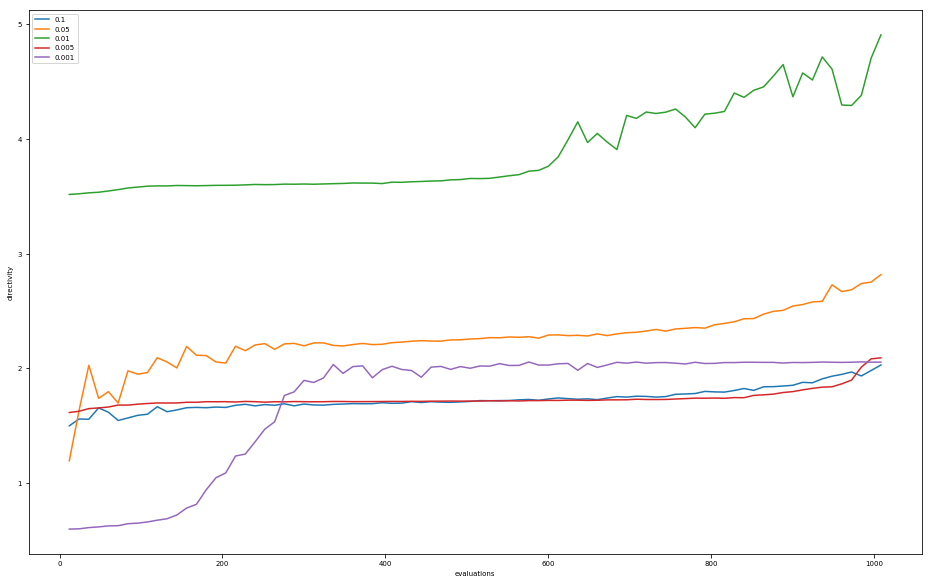

In [99]:
%%time
results = []
n_it=1000
for l in [.1, .05, .01, 0.005, 0.001]:
    _, _, hist = run_evaluation('CMA', n_it=n_it, layers=5, sigma=l, **limitsdict)
    results.append((hist, str(l)))
    
plt.figure(figsize=(16,10))
plt.xlabel("evaluations")
plt.ylabel("directivity")
for hist,label in results:
    plot_hist(hist, label)
plt.legend();

CMA: best -13.847120288671146 for ind [494.6375825  419.47152263 484.63335831   0.82746397]
CMA: best -5.640159104055939 for ind [5.06814904e+01 2.43439741e+02 3.95635629e+02 2.77498441e-01]
CMA: best -19.221431239731267 for ind [440.02039026 138.0814737  112.20308464   0.58496051]
CMA: best -8.735662595527563 for ind [2.84496521e+02 4.34337643e+02 4.70015607e+02 6.54594102e-02]
CMA: best -7.878017256174687 for ind [234.69152109 267.60293931 354.29266233   0.50310993]
CMA: best -13.06602698258059 for ind [1.49577774e+02 4.77961780e+02 4.76689801e+02 1.64498611e-01]
CMA: best -9.421598523306413 for ind [2.17711403e+02 1.33814113e+02 1.86422730e+02 6.32259309e-03]
CMA: best -2.6724366362872933 for ind [4.13698045e+01 2.13237380e+02 4.16631878e+02 3.96332936e-01]
CMA: best -20.157587439613245 for ind [491.80923426 104.89738788 186.11885656   0.95116715]
CMA: best -3.9243247800269327 for ind [336.62346367  15.41462371 496.35356976   0.89555989]
CPU times: user 29 s, sys: 4.89 ms, total: 29

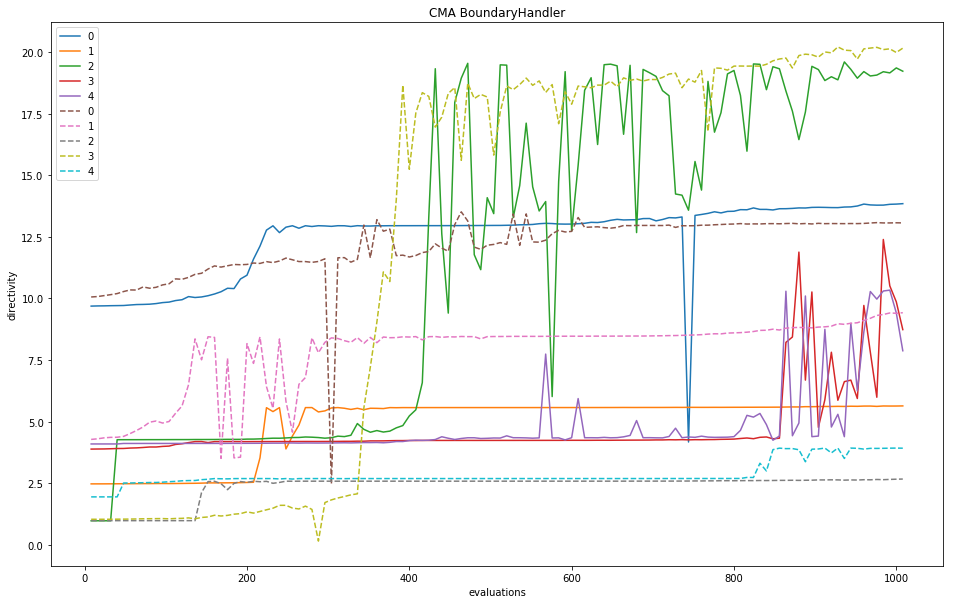

In [52]:
%%time
props = [
    ('BoundTransform', '-'),
    ('BoundPenalty', '--')
]

results = []
n_it=1000
retries=5
for prop,linestyle in props:
    for l in range(retries):
        _, _, hist = run_evaluation('CMA', n_it=n_it, layers=2, sigma=0.1, **limitsdict)
        results.append((hist, str(l), linestyle))

plt.figure(figsize=(16,10))
plt.xlabel("evaluations")
plt.ylabel("directivity")
plt.title("CMA BoundaryHandler")
for hist,label,linestyle in results:
    plot_hist(hist, label, linestyle)
plt.legend();

In [169]:
%%time

props = [
    ('True', 'True'),
    (cma.sigma_adaptation.CMAAdaptSigmaCSA, 'CMAAdaptSigmaCSA'),
    #(cma.sigma_adaptation.CMAAdaptSigmaDistanceProportional, 'CMAAdaptSigmaDistanceProportional'),
    (cma.sigma_adaptation.CMAAdaptSigmaMedianImprovement, 'CMAAdaptSigmaMedianImprovement'),
    (cma.sigma_adaptation.CMAAdaptSigmaNone, 'CMAAdaptSigmaNone'),
    (cma.sigma_adaptation.CMAAdaptSigmaTPA, 'CMAAdaptSigmaTPA')
]
results = []
n_it=1000
retries=10

for adapt_sigma, adapt_sigma_name in props:
    kek = []
    for _ in range(retries):
        _, _, hist = run_evaluation('CMA', n_it=n_it, layers=5, sigma=0.01, adapt_sigma=adapt_sigma, log=False,
                                    **limitsdict)
        kek.append(hist[-1][1])
    print("{}: {}".format(adapt_sigma_name, np.array(kek).mean()))

True: 2.93428915339
CMAAdaptSigmaCSA: 3.39615766555
CMAAdaptSigmaMedianImprovement: 2.79057323105
CMAAdaptSigmaNone: 2.71452482872
CMAAdaptSigmaTPA: 4.22864955801
CPU times: user 10min 42s, sys: 8min 54s, total: 19min 37s
Wall time: 6min 36s


In [7]:
%%time

results = []
n_it=1000
retries=1
for sbbx_eta in [0.001, .01, .1, .5, 1.0, 1.5, 5.0, 10.0, 100.0]:
    kek = []
    for _ in range(retries):
        _, _, hist = run_evaluation('genetic', n_it=n_it, layers=5, sbbx_eta=sbbx_eta, log=False, **limitsdict)
        kek.append(hist[-1][1])
    print("{}: {}".format(sbbx_eta, np.array(kek).mean()))

0.001: 31.17118922716236
0.01: 28.03126336749275
0.1: 30.49677506996459
0.5: 32.29654404722502
1.0: 24.642786434314118
1.5: 27.545938087356607
5.0: 27.037852676691145
10.0: 32.192838452571216
100.0: 25.837655945598023
CPU times: user 1min 8s, sys: 23.5 ms, total: 1min 8s
Wall time: 1min 8s


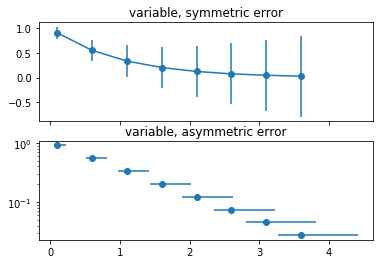

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# example data
x = np.arange(0.1, 4, 0.5)
y = np.exp(-x)

# example error bar values that vary with x-position
error = 0.1 + 0.2 * x

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)
ax0.errorbar(x, y, yerr=error, fmt='-o')
ax0.set_title('variable, symmetric error')

# error bar values w/ different -/+ errors that
# also vary with the x-position
lower_error = 0.4 * error
upper_error = error
asymmetric_error = [lower_error, upper_error]

ax1.errorbar(x, y, xerr=asymmetric_error, fmt='o')
ax1.set_title('variable, asymmetric error')
ax1.set_yscale('log')
plt.show()


In [40]:
DEFAULT_SIGMA=0.5

genetic: best 13.148146672689398 for ind [20.906738035729536, 199.97069128334857, 146.22810602984802, 3.000006509020041, 0.004214011618311539, 7.061226453302728, 0.009834701091902636, 5.719049551512404, 6.664037702529689e-07, 247.32613088077895]
JADE: best 23.076794588161977 for ind [1.98935042e+02 7.23932774e+01 2.00000000e+02 3.66485614e+00
 3.10841129e-03 5.49523004e+00 4.00000000e-01 8.67637425e+00
 0.00000000e+00 2.12695322e+02]
genetic: best 27.47030109346312 for ind [276.62314538464045, 239.96405917844487, 170.7341602969734, 9.783800515284018, 3.688770847478087e-08, 3.8840287293114355, 7.978979692016063e-09, 5.340513196829484, 9.862468261423058e-08, 138.02976146213564]
JADE: best 26.53278572000044 for ind [2.94206993e+02 1.88551706e+02 2.21217846e+02 3.00000000e+00
 0.00000000e+00 7.83140684e+00 0.00000000e+00 9.82016450e+00
 1.06872536e-04 2.93036387e+02]
genetic: best 31.26342244126258 for ind [399.58007260592535, 113.03677546311914, 243.7432332850563, 9.437105065027772, 0.032

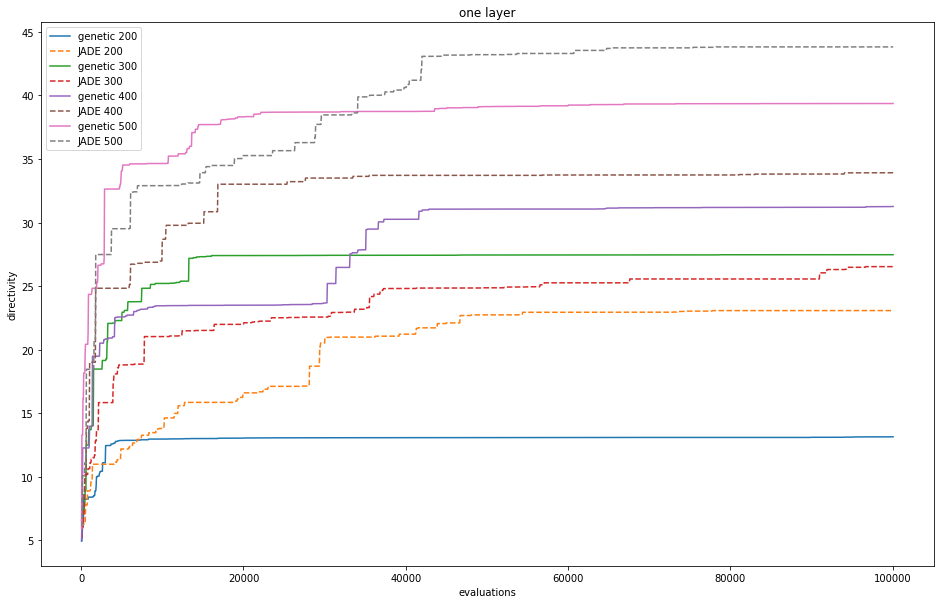

In [74]:
%%time
n_it=100000
limitsdict = {'r_limits':(10,200), 'm_limits':(3, 10), 'mj_limits':(0, 0.4)}
_, _, gen_hist1 = run_evaluation('genetic', n_it=n_it, layers=3, **limitsdict)
_, _, jade_hist1 = run_evaluation('JADE', n_it=n_it, layers=3, **limitsdict)
np.savetxt('exp1/gen200.txt', gen_hist1)
np.savetxt('exp1/jade200.txt', jade_hist1)

limitsdict = {'r_limits':(10,300), 'm_limits':(3, 10), 'mj_limits':(0, 0.4)}
_, _, gen_hist2 = run_evaluation('genetic', n_it=n_it, layers=3, **limitsdict)
_, _, jade_hist2 = run_evaluation('JADE', n_it=n_it, layers=3, **limitsdict)
np.savetxt('exp1/gen300.txt', gen_hist2)
np.savetxt('exp1/jade300.txt', jade_hist2)

limitsdict = {'r_limits':(10,400), 'm_limits':(3, 10), 'mj_limits':(0, 0.4)}
_, _, gen_hist3 = run_evaluation('genetic', n_it=n_it, layers=3, **limitsdict)
_, _, jade_hist3 = run_evaluation('JADE', n_it=n_it, layers=3, **limitsdict)
np.savetxt('exp1/gen400.txt', gen_hist3)
np.savetxt('exp1/jade400.txt', jade_hist3)

limitsdict = {'r_limits':(10,500), 'm_limits':(3, 10), 'mj_limits':(0, 0.4)}
_, _, gen_hist4 = run_evaluation('genetic', n_it=n_it, layers=3, **limitsdict)
_, _, jade_hist4 = run_evaluation('JADE', n_it=n_it, layers=3, **limitsdict)
np.savetxt('exp1/gen500.txt', gen_hist4)
np.savetxt('exp1/jade500.txt', jade_hist4)

plt.figure(figsize=(16,10))
plt.xlabel("evaluations")
plt.ylabel("directivity")
plt.title("one layer")
plot_hist(gen_hist1, "genetic 200", '-')
plot_hist(jade_hist1, "JADE 200", '--')
plot_hist(gen_hist2, "genetic 300", '-')
plot_hist(jade_hist2, "JADE 300", '--')
plot_hist(gen_hist3, "genetic 400", '-')
plot_hist(jade_hist3, "JADE 400", '--')
plot_hist(gen_hist4, "genetic 500", '-')
plot_hist(jade_hist4, "JADE 500", '--')
plt.legend();

In [36]:
np.savetxt('exp1/gen200.txt', gen_hist1)

CMA: best -18.762791320008734 for ind [7.40386630e+01 3.69661029e+02 1.00000000e+01 7.11248398e-19
 3.41390141e+00 1.05409723e-18 1.27558939e+02]
1+1: best 33.77913993704108 for ind [481.31254382167106, 486.40581147533993, 3.610800385295779, 0, 6.068148372967908, 0.14018625732741555, 433.2741970112864]
genetic: best 44.11439604460958 for ind [478.06468591227485, 424.2163755476385, 5.156997013536073, 4.212377413957171e-15, 3.9450812552287515, 0.0012997316785965537, 356.39957570880455]
JADE: best 48.798084468017315 for ind [1.97500690e+02 4.98425065e+02 5.24591591e+00 0.00000000e+00
 7.08105044e+00 1.68820750e-05 1.95041841e+02]
DE: best 39.65252899633536 for ind [4.99288229e+02 2.85544509e+02 6.76459730e+00 0.00000000e+00
 4.40944818e+00 8.73485876e-04 2.90658994e+02]
CPU times: user 2h 20min 4s, sys: 18min 19s, total: 2h 38min 24s
Wall time: 2h 11min 30s


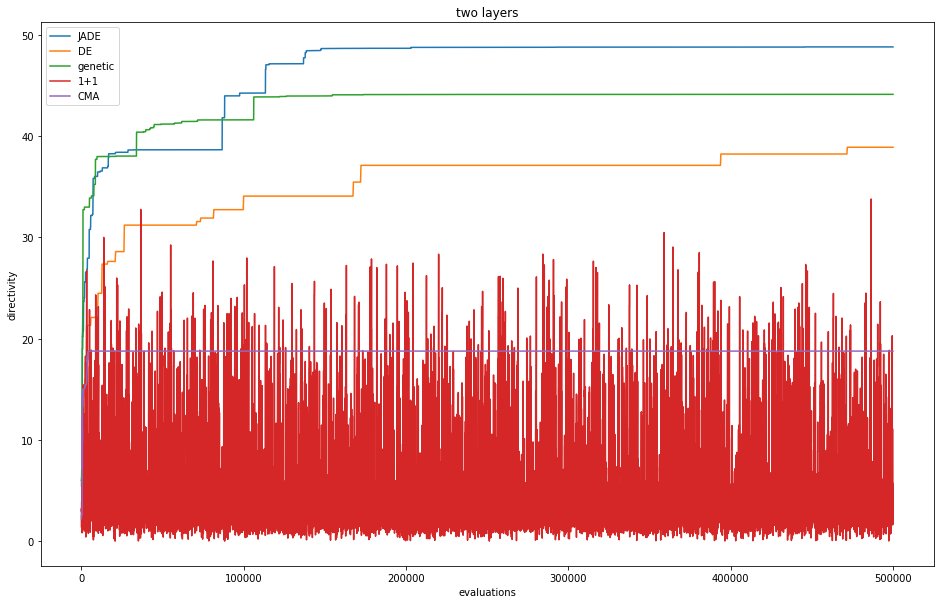

In [75]:
%%time
n_it=500000
limitsdict = {'r_limits':(10,500), 'm_limits':(3, 10), 'mj_limits':(0, 0.4)}
_, _, cma_hist = run_evaluation('CMA', n_it=n_it, layers=2, sigma=0.1, **limitsdict)
np.savetxt('exp2/cma.txt', cma_hist)
_, _, opo_hist = run_evaluation('1+1', n_it=n_it, layers=2, **limitsdict)
np.savetxt('exp2/opo.txt', opo_hist)
_, _, gen_hist = run_evaluation('genetic', n_it=n_it, layers=2, **limitsdict)
np.savetxt('exp2/gen.txt', gen_hist)
_, _, jade_hist = run_evaluation('JADE', n_it=n_it, layers=2, **limitsdict)
np.savetxt('exp2/jade.txt', jade_hist)
_, _, de_hist = run_evaluation('DE', n_it=n_it, layers=2, **limitsdict)
np.savetxt('exp2/de.txt', de_hist)

plt.figure(figsize=(16,10))
plt.xlabel("evaluations")
plt.ylabel("directivity")
plt.title("two layers")
plot_hist(jade_hist, "JADE")
plot_hist(de_hist, "DE")
plot_hist(gen_hist, "genetic")
plot_hist(opo_hist, "1+1")
plot_hist(cma_hist, "CMA")
plt.legend();

1+1: best 34.526853280042424 for ind [500, 494.100003187119, 498.7063227903615, 0.774551964134775]
genetic: best 32.29635581476514 for ind [16.817191045624767, 448.78598365515563, 448.7874238113353, 0.5937025705016921]
JADE: best 34.69324070236129 for ind [4.93961221e+02 5.00000000e+02 4.97498481e+02 5.92655811e-02]
DE: best 37.69010885164645 for ind [489.83793654 374.24031288 267.56363349   0.71073877]
CMA: best -29.368873757318667 for ind [345.23138205 213.33345273 342.04198154   0.7703452 ]
CPU times: user 20min 21s, sys: 484 ms, total: 20min 21s
Wall time: 20min 19s


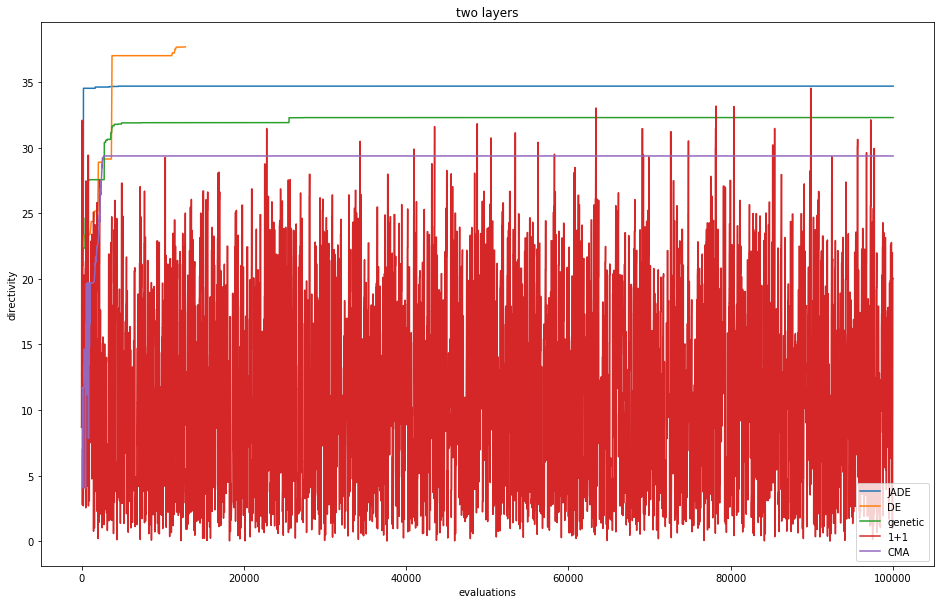

In [12]:
%%time
n_it=100000
_, _, opo_hist = run_evaluation('1+1', n_it=n_it, layers=2, **limitsdict)
_, _, gen_hist = run_evaluation('genetic', n_it=n_it, layers=2, **limitsdict)
_, _, jade_hist = run_evaluation('JADE', n_it=n_it, layers=2, **limitsdict)
_, _, de_hist = run_evaluation('DE', n_it=n_it, layers=2, **limitsdict)
_, _, cma_hist = run_evaluation('CMA', n_it=n_it, layers=2, sigma=DEFAULT_SIGMA,**limitsdict)

plt.figure(figsize=(16,10))
plt.xlabel("evaluations")
plt.ylabel("directivity")
plt.title("two layers")
plot_hist(jade_hist, "JADE")
plot_hist(de_hist, "DE")
plot_hist(gen_hist, "genetic")
plot_hist(opo_hist, "1+1")
plot_hist(cma_hist, "CMA")
plt.legend();

1+1: best 11.8477321248 for ind [120, 120, 9.060579549467448, 0, 7.455585275038433, 0.10583346058930579, 31.957476667728113]
genetic: best 12.71149781 for ind [118.03754929501177, 112.76688336778388, 7.874350602273081, 1.4912703018930495e-15, 7.077327655069377, 0.00748685250769903, 73.95270895728848]
JADE: best 13.9238502528 for ind [1.19982782e+02 5.41457409e+01 4.91281031e+00 4.68782368e-03
 4.28002718e+00 0.00000000e+00 1.02195744e+02]
DE: best 8.62228774284 for ind [2.43835132e+01 1.04966183e+02 1.00000000e+01 0.00000000e+00
 3.93257205e+00 9.11231378e-03 1.43436107e+02]
CMA: best -8.13649137474 for ind [8.23561583e+01 8.50102832e+01 4.89743318e+00 8.51968598e-19
 3.00000000e+00 8.51114566e-17 5.42037318e+01]
CPU times: user 1h 43min 36s, sys: 16min 43s, total: 2h 20s
Wall time: 1h 35min 52s


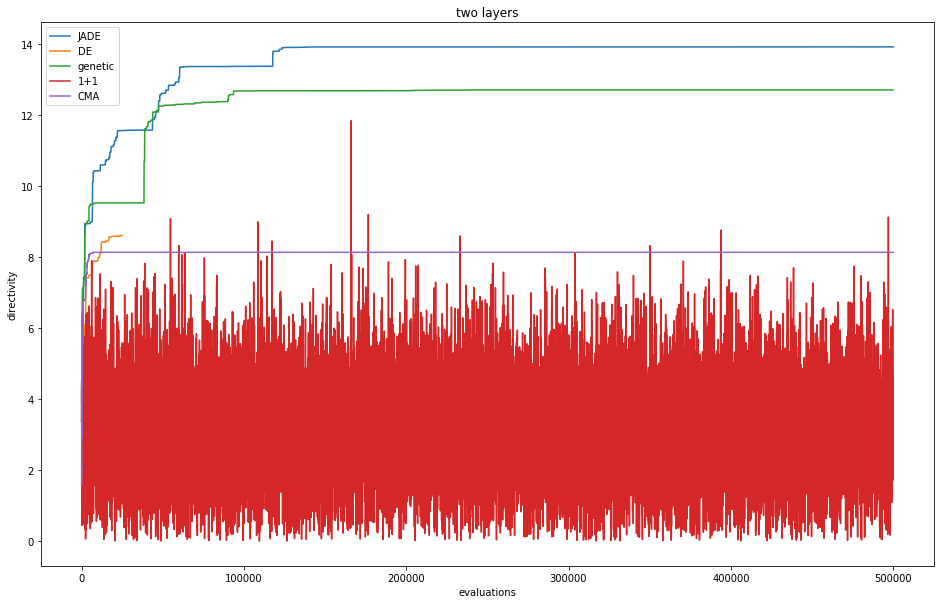

In [9]:
%%time
n_it=500000
_, _, opo_hist = run_evaluation('1+1', n_it=n_it, layers=2, **limitsdict)
_, _, gen_hist = run_evaluation('genetic', n_it=n_it, layers=2, **limitsdict)
_, _, jade_hist = run_evaluation('JADE', n_it=n_it, layers=2, **limitsdict)
_, _, de_hist = run_evaluation('DE', n_it=n_it, layers=2, **limitsdict)
_, _, cma_hist = run_evaluation('CMA', n_it=n_it, layers=2, sigma=0.05,**limitsdict)

plt.figure(figsize=(16,10))
plt.xlabel("evaluations")
plt.ylabel("directivity")
plt.title("two layers")
plot_hist(jade_hist, "JADE")
plot_hist(de_hist, "DE")
plot_hist(gen_hist, "genetic")
plot_hist(opo_hist, "1+1")
plot_hist(cma_hist, "CMA")
plt.legend();

genetic: best 7.01398357437 for ind [24.64032341751166, 59.750340492059294, 4.065159564502595, 5.280620865439349e-06, 5.41882446325796, 0.13676687883543792, 80.0633564014044]
JADE: best 14.8803210874 for ind [3.24149802e+01 1.20000000e+02 3.00000000e+00 4.95968561e-02
 7.81339750e+00 7.04762937e-04 7.74586693e+01]
CMA: best -9.68859770115 for ind [8.10075656e+01 4.53673973e+01 1.00000000e+01 9.42860163e-03
 6.10268257e+00 3.16942620e-15 4.52875485e+01]
CPU times: user 4min 49s, sys: 1min 5s, total: 5min 54s
Wall time: 4min 19s


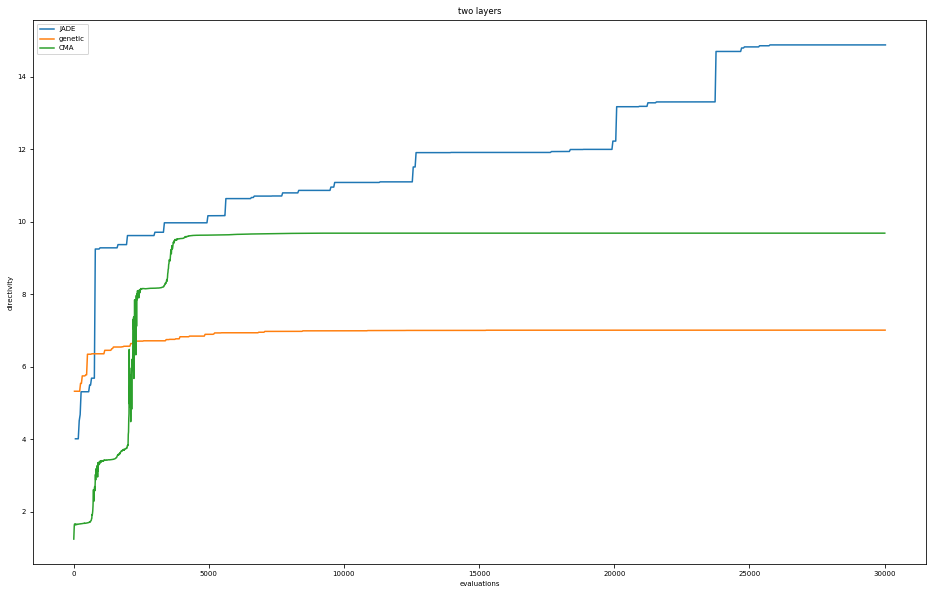

In [194]:
%%time
n_it=30000
#_, _, opo_hist = run_evaluation('1+1', n_it=n_it, layers=2, **limitsdict)
_, _, gen_hist = run_evaluation('genetic', n_it=n_it, layers=2, **limitsdict)
_, _, jade_hist = run_evaluation('JADE', n_it=n_it, layers=2, **limitsdict)
#_, _, de_hist = run_evaluation('DE', n_it=n_it, layers=2, **limitsdict)
_, _, cma_hist = run_evaluation('CMA', n_it=n_it, layers=2, sigma=0.05,**limitsdict)

plt.figure(figsize=(16,10))
plt.xlabel("evaluations")
plt.ylabel("directivity")
plt.title("two layers")
plot_hist(jade_hist, "JADE")
#plot_hist(de_hist, "DE")
plot_hist(gen_hist, "genetic")
#plot_hist(opo_hist, "1+1")
plot_hist(cma_hist, "CMA")
plt.legend();

JADE: best 13.1185428367 for ind [1.08807829e+02 2.32469770e+01 1.00000000e+01 3.16475907e-03
 8.64215340e+00 2.29710682e-01 5.61761105e+01]
JADE: best 16.2814666786 for ind [ 30.04000336  27.56896884 101.03937372   5.8513105    0.4
   8.09406993   0.           9.29020255   0.          85.8403006 ]
JADE: best 21.144599541 for ind [3.61111246e+01 5.47024242e+01 1.20000000e+02 1.99329994e+01
 4.12070547e+00 1.66273397e-02 1.00000000e+01 0.00000000e+00
 6.32775750e+00 0.00000000e+00 5.48181762e+00 1.48527394e-01
 1.18979479e+02]
JADE: best 20.5771115585 for ind [1.19980970e+02 3.40697646e+01 1.20000000e+02 6.31655696e+01
 3.51524855e+01 7.99765756e+00 2.87850911e-03 6.55382203e+00
 0.00000000e+00 3.40555617e+00 0.00000000e+00 9.99382396e+00
 0.00000000e+00 3.76495390e+00 2.94183744e-01 1.17653461e+02]
JADE: best 20.6665107559 for ind [1.51397094e+01 1.20000000e+02 5.22886810e+01 2.35584764e+01
 1.20000000e+02 4.47622116e+01 1.00000000e+01 2.95049104e+01
 5.00949883e+00 3.23622082e-01 5.62

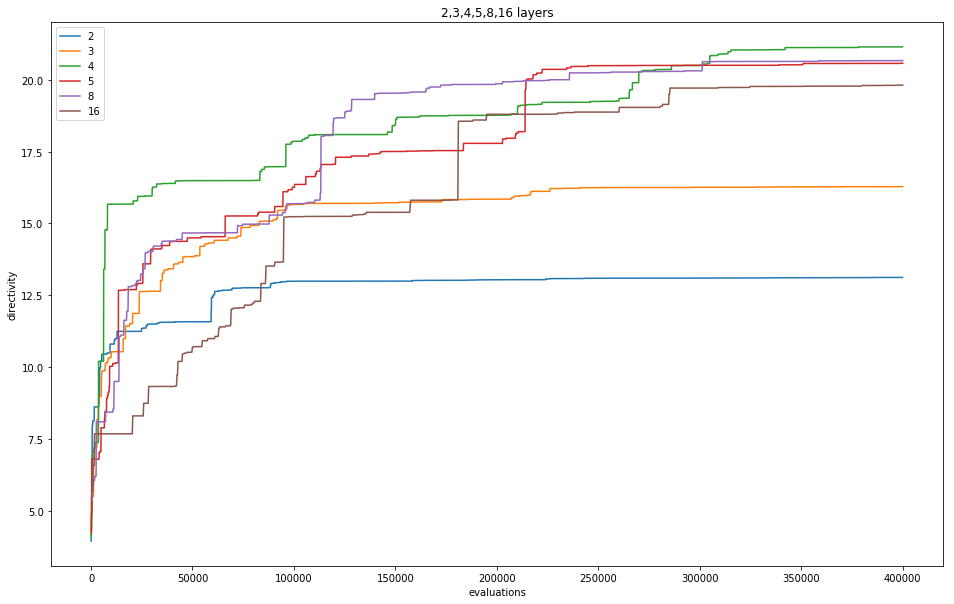

In [9]:
%%time
results = []
n_it=400000
for l in [2,3,4,5,8,16]:
    _, _, hist = run_evaluation('JADE', n_it=n_it, layers=l, **limitsdict)
    results.append((hist, str(l)))
    
plt.figure(figsize=(16,10))
plt.xlabel("evaluations")
plt.ylabel("directivity")
plt.title("2,3,4,5,8,16 layers")
for hist,label in results:
    plot_hist(hist, label)
plt.legend();

JADE: best 14.8396941054 for ind [1.20000000e+02 1.76943405e+01 6.31657860e+00 2.37913059e-04
 3.00000000e+00 0.00000000e+00 1.20002184e+02]
JADE: best 17.9244763458 for ind [1.20000000e+02 2.66102088e+01 5.14626486e+01 8.78289378e+00
 0.00000000e+00 8.57578787e+00 0.00000000e+00 4.16020978e+00
 6.88637733e-03 1.32009983e+02]
JADE: best 15.8329809541 for ind [2.01233276e+01 1.09112177e+02 4.10576512e+01 5.54244756e+01
 7.55198789e+00 0.00000000e+00 8.43183648e+00 0.00000000e+00
 9.99998162e+00 0.00000000e+00 9.84411669e+00 1.95746247e-04
 1.09129016e+02]
JADE: best 16.9742405495 for ind [6.35598783e+01 6.62479833e+01 1.20000000e+02 5.38282502e+01
 4.08887768e+01 5.45604586e+00 7.15435275e-02 6.68782076e+00
 0.00000000e+00 5.62638356e+00 0.00000000e+00 3.00000000e+00
 3.15104374e-01 7.97718156e+00 3.63551625e-01 1.32644563e+02]
CPU times: user 2h 21min 22s, sys: 1.34 s, total: 2h 21min 24s
Wall time: 2h 21min 21s


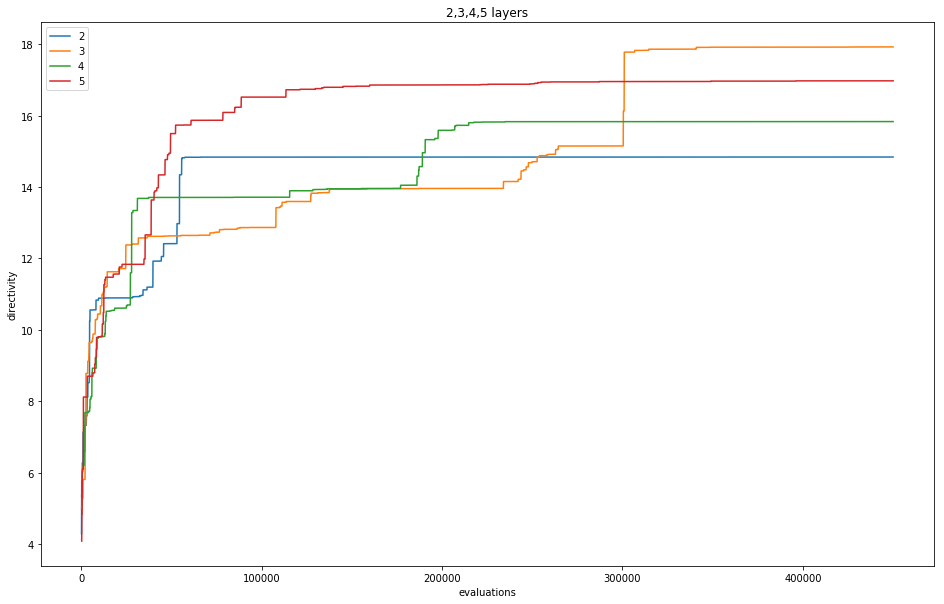

In [10]:
%%time
results = []
n_it=450000
for l in [2,3,4,5]:
    _, _, hist = run_evaluation('JADE', n_it=n_it, layers=l, **limitsdict)
    results.append((hist, str(l)))
    
plt.figure(figsize=(16,10))
plt.xlabel("evaluations")
plt.ylabel("directivity")
plt.title("2,3,4,5 layers")
for hist,label in results:
    plot_hist(hist, label)
plt.legend();

In [ ]:
%%time
results = []
n_it=1000000
_, _, jade_hist = run_evaluation('JADE', n_it=n_it, layers=4, **limitsdict)
_, _, cma_hist = run_evaluation('CMA', n_it=n_it, layers=4, sigma=0.05, **limitsdict)
_, _, gen_hist = run_evaluation('genetic', n_it=n_it, layers=4, **limitsdict)
    
plt.figure(figsize=(16,10))
plt.xlabel("evaluations")
plt.ylabel("directivity")
plt.title("jade vs CMA vs genetic, 4 layers")

plot_hist(jade_hist, "JADE")
plot_hist(cma_hist, "CMA")
plot_hist(gen_hist, "genetic")

plt.legend();

In [ ]:
%%time
results = []
n_it=500000
lld = {'r_limits':(10,480), 'm_limits':(3, 30), 'mj_limits':(0, 0.4)}
_, _, jade_hist = run_evaluation('JADE', n_it=n_it, layers=4, **lld)
_, _, cma_hist = run_evaluation('CMA', n_it=n_it, layers=4, sigma=0.05, **lld)
_, _, gen_hist = run_evaluation('genetic', n_it=n_it, layers=4, **lld)
    
plt.figure(figsize=(16,10))
plt.xlabel("evaluations")
plt.ylabel("directivity")
plt.title("jade vs CMA vs genetic, larger searchspace, 3 layers")

plot_hist(jade_hist, "JADE")
plot_hist(cma_hist, "CMA")
plot_hist(gen_hist, "genetic")

plt.legend();

JADE: best 13.3814266667 for ind [ 77.16719672  46.3696936  120.           8.41984804   0.
   7.12715567   0.           4.49615647   0.          97.26805891]
JADE: best 12.9114497828 for ind [76.00413491 38.43689814 85.43505953 57.47127346 30.38085629 34.17194505
 81.2257895  43.42046275  6.09063117  0.          4.5774847   0.
  6.79490983  0.          8.52868519  0.         10.          0.
  5.81693391  0.          8.06413585  0.          5.6769564   0.
 81.346377  ]
JADE: best 26.502937358 for ind [2.40000000e+02 1.82528092e+02 1.00000000e+01 1.79517996e+01
 0.00000000e+00 1.78905634e+01 0.00000000e+00 3.00000000e+01
 2.23454066e-02 4.07718616e+01]
JADE: best 22.4247120311 for ind [1.00000000e+01 2.40000000e+02 1.10715848e+02 1.06855475e+02
 2.40000000e+02 1.95357427e+02 1.59385646e+01 9.90437309e+01
 3.00000000e+01 1.07934066e-01 1.55275872e+01 0.00000000e+00
 1.90511383e+01 2.71669220e-01 2.96146258e+01 0.00000000e+00
 2.88926277e+01 3.61366144e-01 3.00000000e+00 0.00000000e+00
 1.

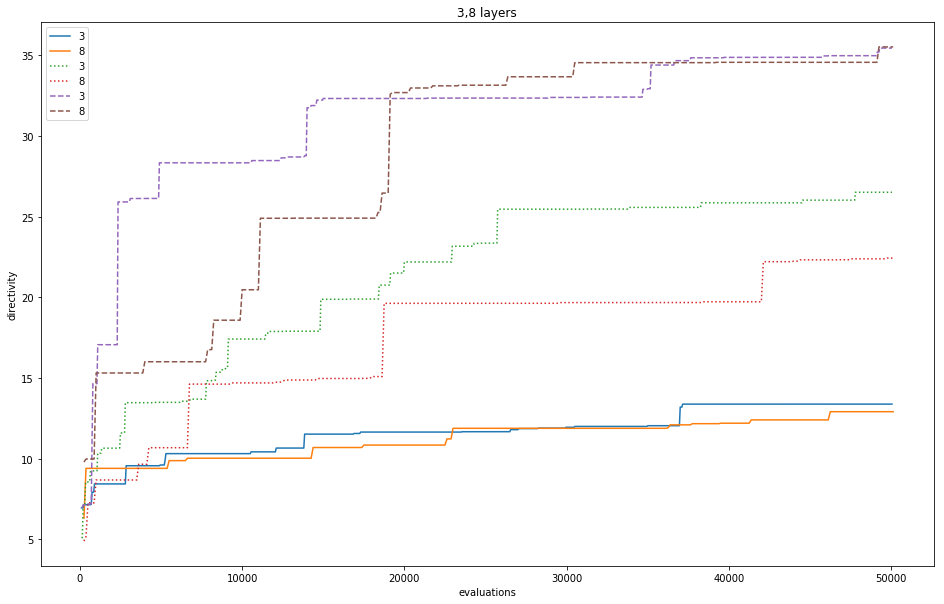

In [11]:
%%time
limitsdicts = [
    ({'r_limits':(10,120), 'm_limits':(3, 10), 'mj_limits':(0, 0.0)}, '-'),
    ({'r_limits':(10,240), 'm_limits':(3, 30), 'mj_limits':(0, 0.4)}, ':'),
    ({'r_limits':(10,480), 'm_limits':(3, 30), 'mj_limits':(0, 0.4)}, '--')
]

results = []
n_it=50000
for ld,linestyle in limitsdicts:
    for l in [3,8]:
        _, _, hist = run_evaluation('JADE', n_it=n_it, layers=l, **ld)
        results.append((hist, str(l), linestyle))

plt.figure(figsize=(16,10))
plt.xlabel("evaluations")
plt.ylabel("directivity")
plt.title("3,8 layers")
for hist,label,linestyle in results:
    plot_hist(hist, label, linestyle)
plt.legend();

JADE: best 47.2085270773 for ind [4.79998002e+02 4.80000000e+02 3.73759333e+00 0.00000000e+00
 2.92010751e+01 2.63558347e-03 3.46066958e+02]
JADE: best 133.645049194 for ind [5.94770935e+01 4.21964023e+02 4.68040018e+01 5.21754838e+00
 1.35996252e-01 3.00000000e+01 0.00000000e+00 2.76896602e+01
 0.00000000e+00 4.06161073e+02]
JADE: best 205.326334608 for ind [4.80000000e+02 1.00000000e+01 4.30562668e+02 1.00000000e+01
 1.22378250e+01 0.00000000e+00 2.05215895e+01 0.00000000e+00
 2.95931062e+01 0.00000000e+00 3.06694563e+00 1.97383589e-02
 4.79597204e+02]
JADE: best 203.782117316 for ind [1.02218928e+02 1.00000000e+01 4.64880646e+02 4.39481539e+02
 1.00000000e+01 3.00000000e+01 2.13488080e-04 1.20976912e+01
 0.00000000e+00 4.85937965e+00 1.13826736e-03 2.51360444e+01
 0.00000000e+00 3.00000000e+00 2.11195345e-01 4.22322291e+02]
CPU times: user 2h 4min 1s, sys: 1.34 s, total: 2h 4min 3s
Wall time: 2h 4min 1s


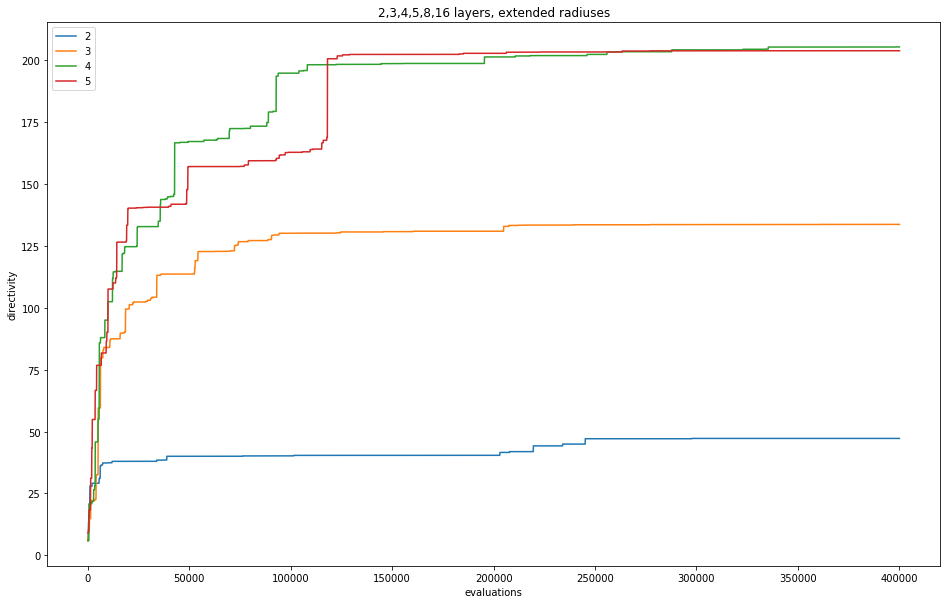

In [11]:
%%time
ld={'r_limits':(10,480), 'm_limits':(3, 30), 'mj_limits':(0, 0.4)}
results = []
n_it=400000
for l in [2,3,4,5]:
    _, _, hist = run_evaluation('JADE', n_it=n_it, layers=l, **ld)
    results.append((hist, str(l)))
    
plt.figure(figsize=(16,10))
plt.xlabel("evaluations")
plt.ylabel("directivity")
plt.title("2,3,4,5 layers, extended radiuses")
for hist,label in results:
    plot_hist(hist, label)
plt.legend();

genetic: best 36.7907815168 for ind [135.43098720716443, 480, 383.4049689277377, 22.545017210656976, 0.0, 7.820260613157036, 0.0, 5.358803000074694, 0.0, 225.38614554159892]
JADE: best 71.5212522118 for ind [ 25.8982234   27.9769154  448.28985726   3.94830405   0.
   5.66336441   0.          22.91389878   0.         162.36078327]
CPU times: user 53min 14s, sys: 1.02 s, total: 53min 15s
Wall time: 53min 14s


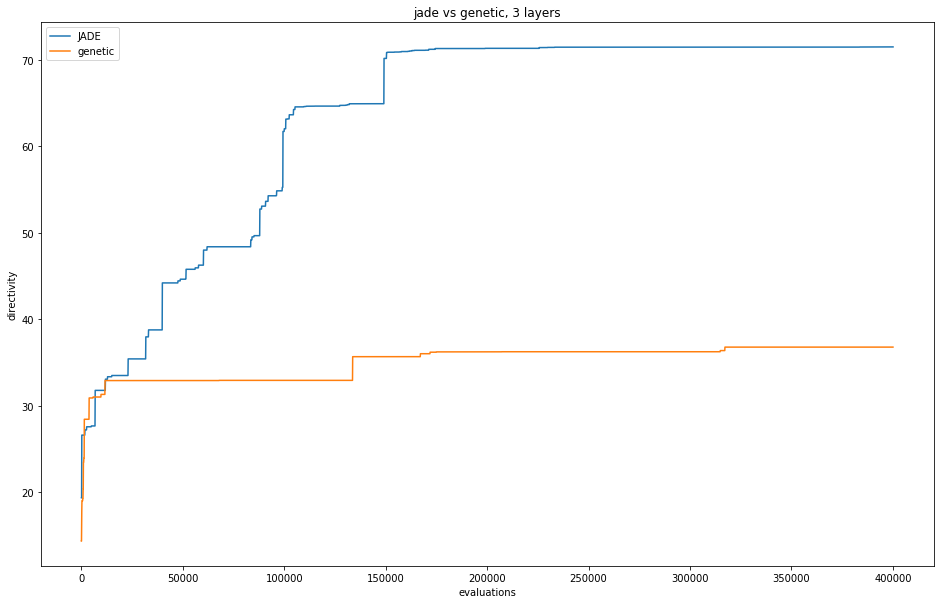

In [12]:
%%time
n_it=400000
ld={'r_limits':(10,480), 'm_limits':(3, 30), 'mj_limits':(0., 0.)}
_, _, gen_hist = run_evaluation('genetic', n_it=n_it, layers=3, **ld)
_, _, jade_hist = run_evaluation('JADE', n_it=n_it, layers=3, **ld)

plt.figure(figsize=(16,10))
plt.xlabel("evaluations")
plt.ylabel("directivity")
plt.title("jade vs genetic, 3 layers")
plot_hist(jade_hist, "JADE")
plot_hist(gen_hist, "genetic")
plt.legend();

genetic: best 41.4449324427 for ind [350.3244382887118, 347.7785873206704, 72.38875241013842, 362.2199410239918, 3.1842770339563526, 0.13719823395307232, 7.2661852930310795, 0, 28.480463006699882, 0.035896293233572255, 24.625848298555194, 0.09065703573876607, 335.4792486922464]
JADE: best 48.9117770058 for ind [1.59335269e+02 4.68961350e+02 1.69614876e+02 2.88195845e+02
 2.18166891e+01 3.75383605e-06 4.96352080e+00 0.00000000e+00
 8.53559274e+00 1.95673202e-04 2.25226423e+01 0.00000000e+00
 3.21936560e+01]
CPU times: user 1h 14min 34s, sys: 1.51 s, total: 1h 14min 35s
Wall time: 1h 14min 34s


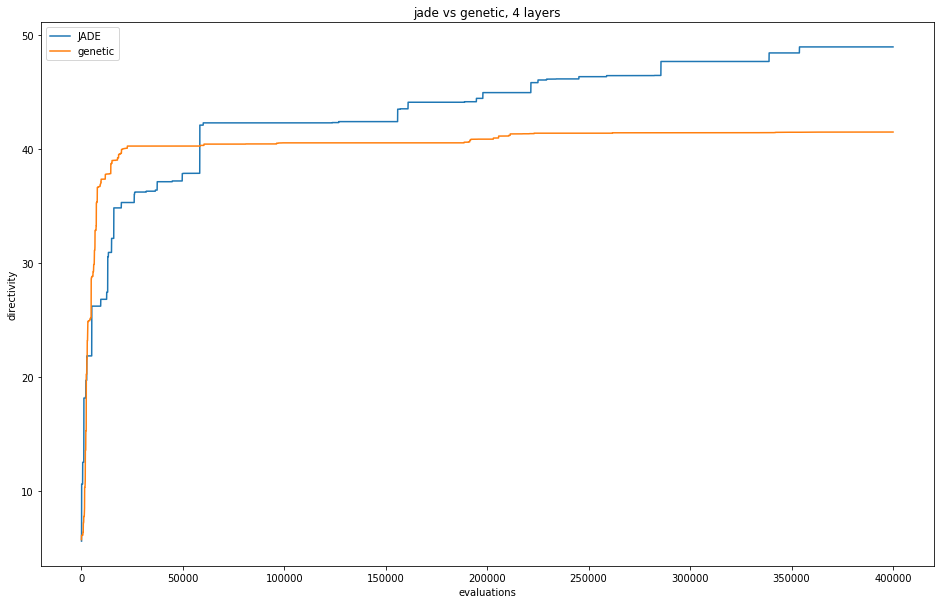

In [12]:
%%time
n_it=400000
_, _, gen_hist = run_evaluation('genetic', n_it=n_it, layers=4, **ld)
_, _, jade_hist = run_evaluation('JADE', n_it=n_it, layers=4, **ld)

plt.figure(figsize=(16,10))
plt.xlabel("evaluations")
plt.ylabel("directivity")
plt.title("jade vs genetic, 4 layers")
plot_hist(jade_hist, "JADE")
plot_hist(gen_hist, "genetic")
plt.legend();

CPU times: user 93.1 ms, sys: 0 ns, total: 93.1 ms
Wall time: 91.9 ms


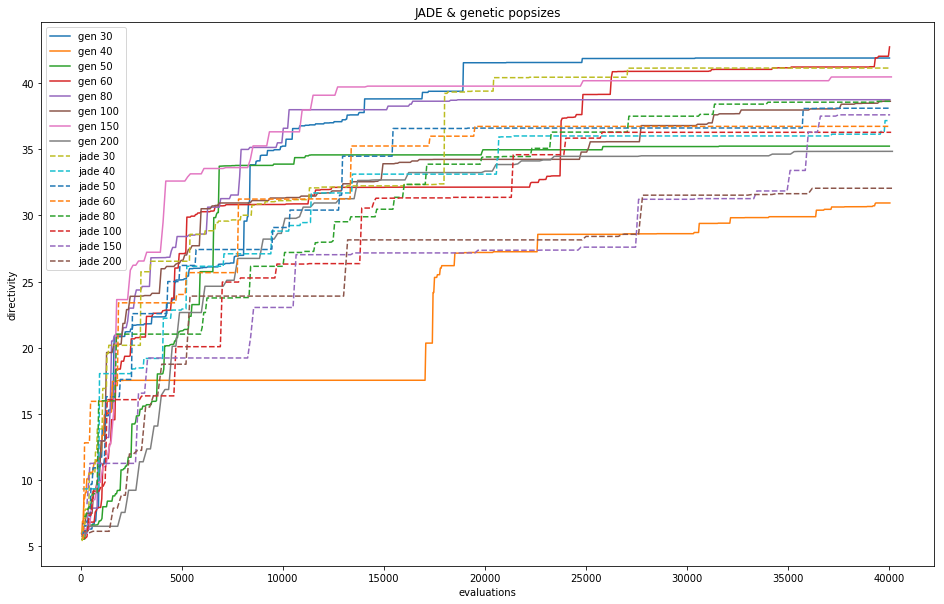

In [18]:
%%time
n_it=40000
popsizes = [30, 40, 50, 60, 80, 100, 150, 200]

gen_results = []
jade_results = []
for popsize in popsizes:
    _, _, hist = run_evaluation('genetic', n_it=n_it, layers=4, popsize=popsize, **ld)
    gen_results.append((hist, "gen {}".format(popsize)))
    _, _, hist = run_evaluation('JADE', n_it=n_it, layers=4, popsize=popsize, **ld)
    jade_results.append((hist, "jade {}".format(popsize)))

plt.figure(figsize=(16,10))
plt.xlabel("evaluations")
plt.ylabel("directivity")
plt.title("JADE & genetic popsizes")
for hist,label in gen_results:
    plot_hist(hist, label)
for hist,label in jade_results:
    plot_hist(hist, label, linestyle='--')
plt.legend();

In [ ]:
def fitness(p):
    x, y = p[0], p[1]
    val = 20 + (x**2 - 10*cos(2*pi*x)) + (y**2 - 10*cos(2*pi*y))
    return -val

results = []
for l in [1,2,4,8,16,5,7,9]:
    _, _, hist = run_evaluation('JADE', n_it=2500, r_limits=(10,120), m_limits=(3, 10), mj_limits=(0, 0.4), 
                                layers=l)
    results.append((hist, str(l)))